Problématique
Le client gère des distributeurs de boissons sur des quais de gare. Un employé passe une fois par semaine recharger les machines. Cet employé indique régulièrement que la machine était vide, mais sans préciser quels produits sont vides. Le client souhaiterait estimer le manque à gagner (lorsqu'il y a rupture de stock), et te demande une analyse détaillée. Il aimerait un conseil pour savoir s'il est rentable d'envoyer ou non l'employé pour recharger les machines deux fois par semaine plutôt qu'une seule fois.

Pour cela, il te fournit l'extraction du journal automatique (le "log") des 4 distributeurs de boisson de la gare concernée. Chaque machine enregistre en effet chaque vente ou passage du technicien avec un horodatage.

 

Quelques compléments (tous les montants sont hors taxe, tu n'as donc pas à prendre en compte les taxes et/ou les impôts dans cette analyse) :

Le déplacement d'un employé coûte 50 euros pour aller à la gare + 20 euros par machine. Les 4 machines sont dans la même gare.
Le prix de vente des boissons est de : 1 euro le café ; 1,60 euros le soda ; 1,80 euros le nrj drink.
Le coût de revient des boissons est de : 30 cts le café ; 60 cts le soda ; 80 cts le nrj drink.
Chaque distributeur a une capacité maximale de : 280 doses de café ; 120 canettes de soda ; 60 bouteilles de nrj drink.
La gare est fermée au public une partie de la nuit.
Le coût de location de l'emplacement pour chaque machine est de 150 euros mensuels.
Les frais d'entretien de chaque machine sont de 1200 euros annuels.

# 1_ Import

In [122]:
import time
import json 
import numpy as np
import pandas as pd
import datetime
import regex as re
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import seaborn as sns
pd.options.mode.chained_assignment = None  # default='warn'

In [123]:
with open(r"C:\Users\manon\Dev\2023_boissons\beverage_dispenser.json") as f:
    data = json.load(f)

# 2_ Création dataframe

In [124]:
# impression uniquement des 10 premieres lignes 
for x in data["content"][:10] : 
    print (x)

{'date': '2019-11-14T11:53:35.000Z', 'product': 'refill', 'machine': 'A'}
{'date': '2019-11-14T12:06:35.000Z', 'product': 'coffee', 'machine': 'A'}
{'date': '2019-11-14T12:07:59.000Z', 'product': 'soda', 'machine': 'A'}
{'date': '2019-11-14T12:13:45.000Z', 'product': 'soda', 'machine': 'A'}
{'date': '2019-11-14T12:22:35.000Z', 'product': 'coffee', 'machine': 'A'}
{'date': '2019-11-14T12:37:44.000Z', 'product': 'soda', 'machine': 'A'}
{'date': '2019-11-14T12:47:09.000Z', 'product': 'refill', 'machine': 'B'}
{'date': '2019-11-14T12:47:52.000Z', 'product': 'coffee', 'machine': 'A'}
{'date': '2019-11-14T12:51:00.000Z', 'product': 'coffee', 'machine': 'A'}
{'date': '2019-11-14T12:52:49.000Z', 'product': 'coffee', 'machine': 'A'}


In [125]:
df_init = pd.json_normalize(data["content"])

# 3_ NaN & duplicated

In [126]:
df_init.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11042 entries, 0 to 11041
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   date     11042 non-null  object
 1   product  11042 non-null  object
 2   machine  11042 non-null  object
dtypes: object(3)
memory usage: 258.9+ KB


In [127]:
df_init.duplicated().sum()

6

In [128]:
df_init[df_init.duplicated()]

,date,product,machine
125,2019-11-14T19:04:03.000Z,soda,D
1495,2019-11-18T12:25:36.000Z,coffee,D
2032,2019-11-22T05:09:25.000Z,coffee,A
2070,2019-11-22T06:40:28.000Z,coffee,A
5012,2019-12-02T08:32:20.000Z,coffee,B
8308,2019-12-14T18:40:49.000Z,nrj,B


In [129]:
df_init.drop_duplicates(inplace=True)

In [130]:
df_init

,date,product,machine
0,2019-11-14T11:53:35.000Z,refill,A
1,2019-11-14T12:06:35.000Z,coffee,A
2,2019-11-14T12:07:59.000Z,soda,A
3,2019-11-14T12:13:45.000Z,soda,A
4,2019-11-14T12:22:35.000Z,coffee,A
...,...,...,...
11037,2019-12-25T20:10:53.000Z,nrj,A
11038,2019-12-25T20:16:30.000Z,nrj,B
11039,2019-12-25T20:26:35.000Z,nrj,B
11040,2019-12-25T21:11:55.000Z,nrj,B


In [131]:
df_init = df_init.sort_values("date").reset_index(drop=True).copy(deep=True)

In [132]:
df_init["date"] = pd.to_datetime(df_init["date"])

In [133]:
df_init["date"].dt.hour

0        11
1        12
2        12
3        12
4        12
         ..
11031    20
11032    20
11033    20
11034    21
11035    21
Name: date, Length: 11036, dtype: int32

# 4_ date_donnée : Produits, tarifs, fees

In [134]:
# details = {date_concernee, [[nom_item1, prix_de_vente, prix_achat, capacite_machine], [nom_item2, prix_de_vente, ...], ... ]}
details_produits = {"2023-11" : {"coffee" : [1, 0.3, 280], "soda" : [1.6, 0.6, 120], "nrj" : [1.8, 0.8, 60]}}

In [135]:
details_produits["2023-11"]

{'coffee': [1, 0.3, 280], 'soda': [1.6, 0.6, 120], 'nrj': [1.8, 0.8, 60]}

In [136]:
details_produits["2023-11"].keys()

dict_keys(['coffee', 'soda', 'nrj'])

In [137]:
details_produits["2023-11"]["coffee"]

[1, 0.3, 280]

In [138]:
# Le coût de location de l'emplacement pour chaque machine est de 150 euros mensuels.
# Les frais d'entretien de chaque machine sont de 1200 euros annuels.
# Le déplacement d'un employé coûte 50 euros pour aller à la gare + 20 euros par machine. Les 4 machines sont dans la même gare.

# 5_ Initialisation suivi temporel

In [139]:
identifiants_machines = list(df_init["machine"].unique())
identifiants_machines

['A', 'B', 'C', 'D']

In [140]:
produits = list(details_produits["2023-11"].keys())
produits

['coffee', 'soda', 'nrj']

In [141]:
def creation_colonnes(df, liste_id_machines, liste_produits) :
    
    jour = {1: "monday", 2:"tuesday", 3 : "wednesday", 4 : "thursday", 5 : "friday", 6 : "saturday", 7 : "sunday"}
    df["month"]=df["date"].dt.month
    df["day"]=df["date"].dt.day
    df["weekday"]=df["date"].dt.isocalendar().day
    df["weekday"]=df["weekday"].astype(int).replace(jour)
    df["hour"]=df["date"].dt.hour
    for machine in liste_id_machines:
        for nom_produit in liste_produits : 
            nom_col = f'{nom_produit}_{machine}'
            df[nom_col] = 0
    return df

In [142]:
df = creation_colonnes(df_init, identifiants_machines, produits)

In [143]:
df

,date,product,machine,month,day,weekday,hour,coffee_A,soda_A,nrj_A,coffee_B,soda_B,nrj_B,coffee_C,soda_C,nrj_C,coffee_D,soda_D,nrj_D
0,2019-11-14 11:53:35+00:00,refill,A,11,14,thursday,11,0,0,0,0,0,0,0,0,0,0,0,0
1,2019-11-14 12:06:35+00:00,coffee,A,11,14,thursday,12,0,0,0,0,0,0,0,0,0,0,0,0
2,2019-11-14 12:07:59+00:00,soda,A,11,14,thursday,12,0,0,0,0,0,0,0,0,0,0,0,0
3,2019-11-14 12:13:45+00:00,soda,A,11,14,thursday,12,0,0,0,0,0,0,0,0,0,0,0,0
4,2019-11-14 12:22:35+00:00,coffee,A,11,14,thursday,12,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11031,2019-12-25 20:10:53+00:00,nrj,A,12,25,wednesday,20,0,0,0,0,0,0,0,0,0,0,0,0
11032,2019-12-25 20:16:30+00:00,nrj,B,12,25,wednesday,20,0,0,0,0,0,0,0,0,0,0,0,0
11033,2019-12-25 20:26:35+00:00,nrj,B,12,25,wednesday,20,0,0,0,0,0,0,0,0,0,0,0,0
11034,2019-12-25 21:11:55+00:00,nrj,B,12,25,wednesday,21,0,0,0,0,0,0,0,0,0,0,0,0


In [144]:
produits

['coffee', 'soda', 'nrj']

In [145]:
# A transformer en fonction par la suite 
for i in range(len(df)) : 
    # si "refill" ou 1ere ligne 
    # recupération machine concernee, 
    # copie ligne précédente, 
    # affectation quantité rechargement chaque item machine
    if df["product"].iat[i] == "refill" or i==0 :
        machine_concernee = df["machine"].iat[i]
        df.iloc[i, 7:] = df.iloc[i-1, 7:]
        for id_prod in produits :
            df[f'{id_prod}_{machine_concernee}'].iat[i] = details_produits["2023-11"][id_prod][2]
    # gestion du stock, on ne soustrait pas quand la quantité est déjà à 0
    else :
        machine_concernee = df["machine"].iat[i]
        produit_concerne = df["product"].iat[i]
        df.iloc[i, 7:] = df.iloc[i-1, 7:]
        if df[f'{produit_concerne}_{machine_concernee}'].iat[i] != 0 : 
            df[f'{produit_concerne}_{machine_concernee}'].iat[i] -=1

In [146]:
df.head(10)

,date,product,machine,month,day,weekday,hour,coffee_A,soda_A,nrj_A,coffee_B,soda_B,nrj_B,coffee_C,soda_C,nrj_C,coffee_D,soda_D,nrj_D
0,2019-11-14 11:53:35+00:00,refill,A,11,14,thursday,11,280,120,60,0,0,0,0,0,0,0,0,0
1,2019-11-14 12:06:35+00:00,coffee,A,11,14,thursday,12,279,120,60,0,0,0,0,0,0,0,0,0
2,2019-11-14 12:07:59+00:00,soda,A,11,14,thursday,12,279,119,60,0,0,0,0,0,0,0,0,0
3,2019-11-14 12:13:45+00:00,soda,A,11,14,thursday,12,279,118,60,0,0,0,0,0,0,0,0,0
4,2019-11-14 12:22:35+00:00,coffee,A,11,14,thursday,12,278,118,60,0,0,0,0,0,0,0,0,0
5,2019-11-14 12:37:44+00:00,soda,A,11,14,thursday,12,278,117,60,0,0,0,0,0,0,0,0,0
6,2019-11-14 12:47:09+00:00,refill,B,11,14,thursday,12,278,117,60,280,120,60,0,0,0,0,0,0
7,2019-11-14 12:47:52+00:00,coffee,A,11,14,thursday,12,277,117,60,280,120,60,0,0,0,0,0,0
8,2019-11-14 12:51:00+00:00,coffee,A,11,14,thursday,12,276,117,60,280,120,60,0,0,0,0,0,0
9,2019-11-14 12:52:49+00:00,coffee,A,11,14,thursday,12,275,117,60,280,120,60,0,0,0,0,0,0


# 6_ Stats

## Passages de l'employé : 

In [147]:
df[df["product"]=="refill"]

,date,product,machine,month,day,weekday,hour,coffee_A,soda_A,nrj_A,coffee_B,soda_B,nrj_B,coffee_C,soda_C,nrj_C,coffee_D,soda_D,nrj_D
0,2019-11-14 11:53:35+00:00,refill,A,11,14,thursday,11,280,120,60,0,0,0,0,0,0,0,0,0
6,2019-11-14 12:47:09+00:00,refill,B,11,14,thursday,12,278,117,60,280,120,60,0,0,0,0,0,0
24,2019-11-14 13:51:23+00:00,refill,C,11,14,thursday,13,268,115,60,275,120,60,280,120,60,0,0,0
43,2019-11-14 14:54:30+00:00,refill,D,11,14,thursday,14,266,114,60,270,119,60,274,118,59,280,120,60
1838,2019-11-21 11:55:39+00:00,refill,A,11,21,thursday,11,280,120,60,0,0,1,0,0,0,1,1,0
1849,2019-11-21 13:33:01+00:00,refill,B,11,21,thursday,13,274,117,60,280,120,60,0,0,0,1,1,0
1860,2019-11-21 14:01:57+00:00,refill,C,11,21,thursday,14,270,116,60,278,118,59,280,120,60,1,1,0
1881,2019-11-21 15:00:58+00:00,refill,D,11,21,thursday,15,264,115,60,273,116,59,279,116,59,280,120,60
3674,2019-11-28 11:54:41+00:00,refill,A,11,28,thursday,11,280,120,60,0,1,0,0,0,0,0,0,0
3682,2019-11-28 12:54:01+00:00,refill,B,11,28,thursday,12,275,118,60,280,120,60,0,0,0,0,0,0


In [148]:
condition = df["product"]=="refill"
df[condition]["hour"].value_counts()

hour
12    6
14    6
11    4
13    4
15    4
Name: count, dtype: int64

In [149]:
temps_de_recharge = df[df["product"]=="refill"]
temps_de_recharge = df[["date,","product","machine"]]
temps_de_recharge["temps_recharge"] = temps_de_recharge["date"].diff()

KeyError: "['date,'] not in index"

In [ ]:
temps_de_recharge["temps_recharge"] = temps_de_recharge["temps_recharge"].apply(lambda x : x.total_seconds()/60)
temps_de_recharge["temps_recharge"] = round(temps_de_recharge["temps_recharge"].mask(temps_de_recharge["temps_recharge"]>=8000, np.nan), 2)

[]

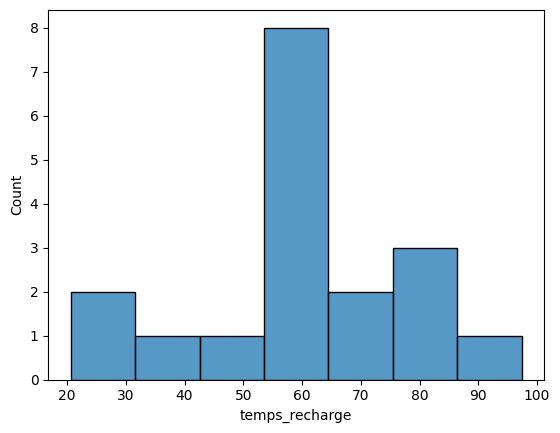

In [ ]:
sns.histplot(data = temps_de_recharge["temps_recharge"]), 
plt.plot()

In [ ]:
temps_de_recharge.head(3)

,date,product,machine,month,day,weekday,hour,coffee_A,soda_A,nrj_A,coffee_B,soda_B,nrj_B,coffee_C,soda_C,nrj_C,coffee_D,soda_D,nrj_D,temps_recharge
0,2019-11-14 11:53:35+00:00,refill,A,11,14,thursday,11,280,120,60,0,0,0,0,0,0,0,0,0,NaN
6,2019-11-14 12:47:09+00:00,refill,B,11,14,thursday,12,278,117,60,280,120,60,0,0,0,0,0,0,53.57
24,2019-11-14 13:51:23+00:00,refill,C,11,14,thursday,13,268,115,60,275,120,60,280,120,60,0,0,0,64.23


In [ ]:
print("Sur un total de", len(temps_de_recharge), "rechargements : ")
print("Rechargement le plus rapide =", round(temps_de_recharge["temps_recharge"].min(),0), "minutes")
print("Rechargement le plus lent= ", round(temps_de_recharge["temps_recharge"].max(),0), "minutes")
print("Rechargement moyen =", round(temps_de_recharge["temps_recharge"].mean(),0), "minutes")
print("Rechargement médian =", round(temps_de_recharge["temps_recharge"].median(),0), "minutes")

Sur un total de 24 rechargements : 
Rechargement le plus rapide = 21.0 minutes
Rechargement le plus lent=  97.0 minutes
Rechargement moyen = 60.0 minutes
Rechargement médian = 60.0 minutes


### Observations : 
Les machines sont actuellement rechargées par l'employé le jeudi entre 11h et 16h00, l'employé passe environ 1h par machine.

In [ ]:
del temps_de_recharge

## Stock

### Ventes journalières

In [165]:
# I'm choosing to display the data starting to the first monday
# The purpused is to display the weekday in order in the next displot. 
# I will deal with the categorical order later

c:\Users\manon\anaconda3\envs\data\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\manon\AppData\Local\Temp\ipykernel_13360\2199030493.py:14: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


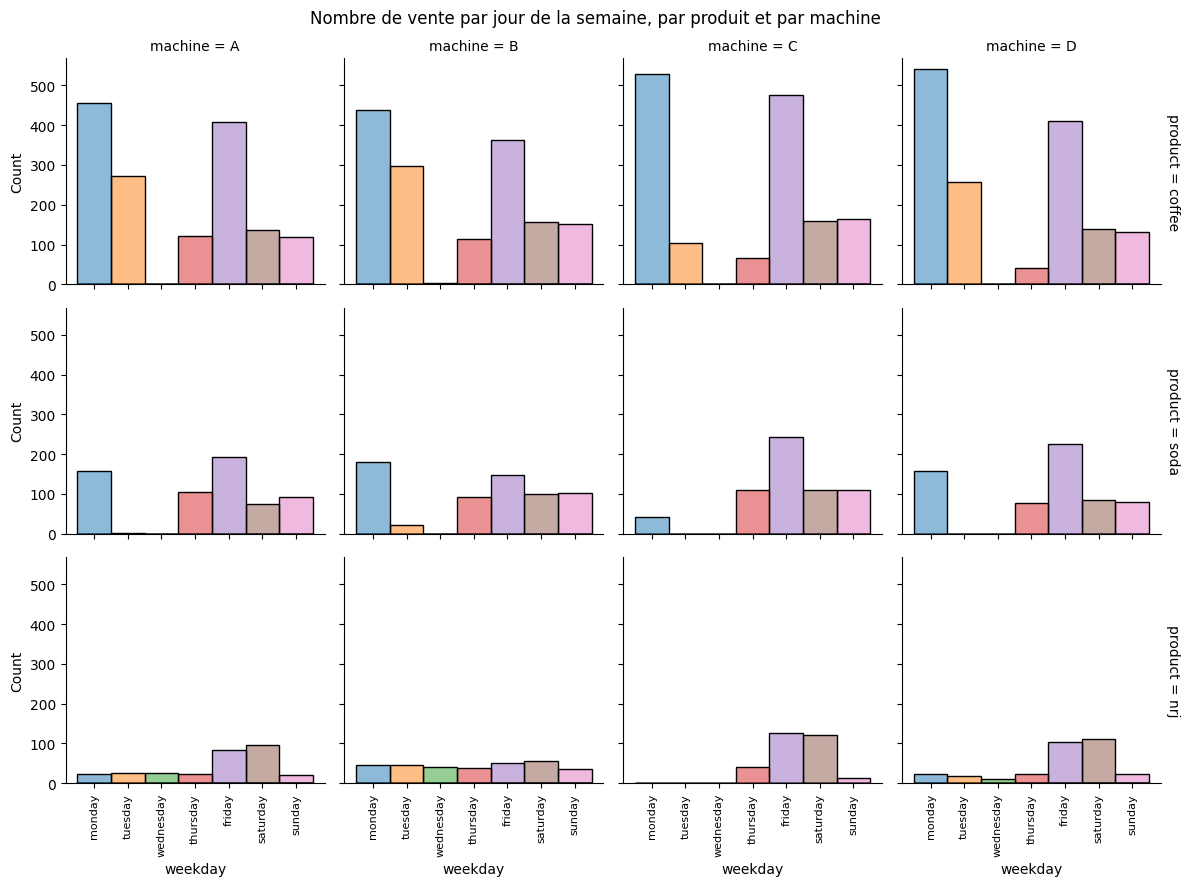

In [283]:
fig, ax = plt.figsize=(10,10)
ax = sns.displot(data=df.iloc[1217:,],
            x="weekday", 
            col="machine", 
            row="product",
            height=3,
            facet_kws=dict(margin_titles=True),
            col_order=["A", "B", "C", "D"],
            row_order=["coffee", "soda", "nrj"],
            hue="weekday",
            legend=False)
ax.tick_params(axis='x', rotation=90, labelsize=8)
plt.suptitle("Nombre de vente par jour de la semaine, par produit et par machine")
plt.tight_layout()
plt.show()


### Evolution du stock par produit

In [255]:
df[["stock_coffee_A","stock_coffee_B","stock_coffee_C","stock_coffee_D"]]= 0, 0, 0, 0
df[["stock_soda_A","stock_soda_B","stock_soda_C","stock_soda_D"]]= 0, 0, 0, 0
df[["stock_nrj_A","stock_nrj_B","stock_nrj_C","stock_nrj_D"]]= 0, 0, 0, 0

In [257]:
df[["stock_coffee_A","stock_coffee_B","stock_coffee_C","stock_coffee_D"]] = round(df[["coffee_A","coffee_B","coffee_C","coffee_D"]]/280,2)*100
df[["stock_soda_A","stock_soda_B","stock_soda_C","stock_soda_D"]] = round(df[["soda_A","soda_B","soda_C","soda_D"]]/120,2)*100
df[["stock_nrj_A","stock_nrj_B","stock_nrj_C","stock_nrj_D"]] = round(df[["nrj_A","nrj_B","nrj_C","nrj_D"]]/60,2)*100

In [258]:
df.head(2)

,date,product,machine,month,day,weekday,hour,coffee_A,soda_A,nrj_A,...,stock_soda_C,stock_soda_D,stock_njr_A,stock_njr_B,stock_njr_C,stock_njr_D,stock_nrj_A,stock_nrj_B,stock_nrj_C,stock_nrj_D
0,2019-11-14 11:53:35+00:00,refill,A,11,14,thursday,11,280,120,60,...,0.0,0.0,100.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0
1,2019-11-14 12:06:35+00:00,coffee,A,11,14,thursday,12,279,120,60,...,0.0,0.0,100.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0


In [261]:
coffee = df.loc[:,["date", "weekday", "machine", "stock_coffee_A","stock_coffee_B","stock_coffee_C","stock_coffee_D"]]
soda = df.loc[:,["date", "weekday", "machine", "stock_soda_A","stock_soda_B","stock_soda_C","stock_soda_D"]]
nrj = df.loc[:,["date", "weekday", "machine", "stock_nrj_A","stock_nrj_B","stock_nrj_C","stock_nrj_D"]]

In [262]:
coffee.head(2)

,date,weekday,machine,stock_coffee_A,stock_coffee_B,stock_coffee_C,stock_coffee_D
0,2019-11-14 11:53:35+00:00,thursday,A,100.0,0.0,0.0,0.0
1,2019-11-14 12:06:35+00:00,thursday,A,100.0,0.0,0.0,0.0


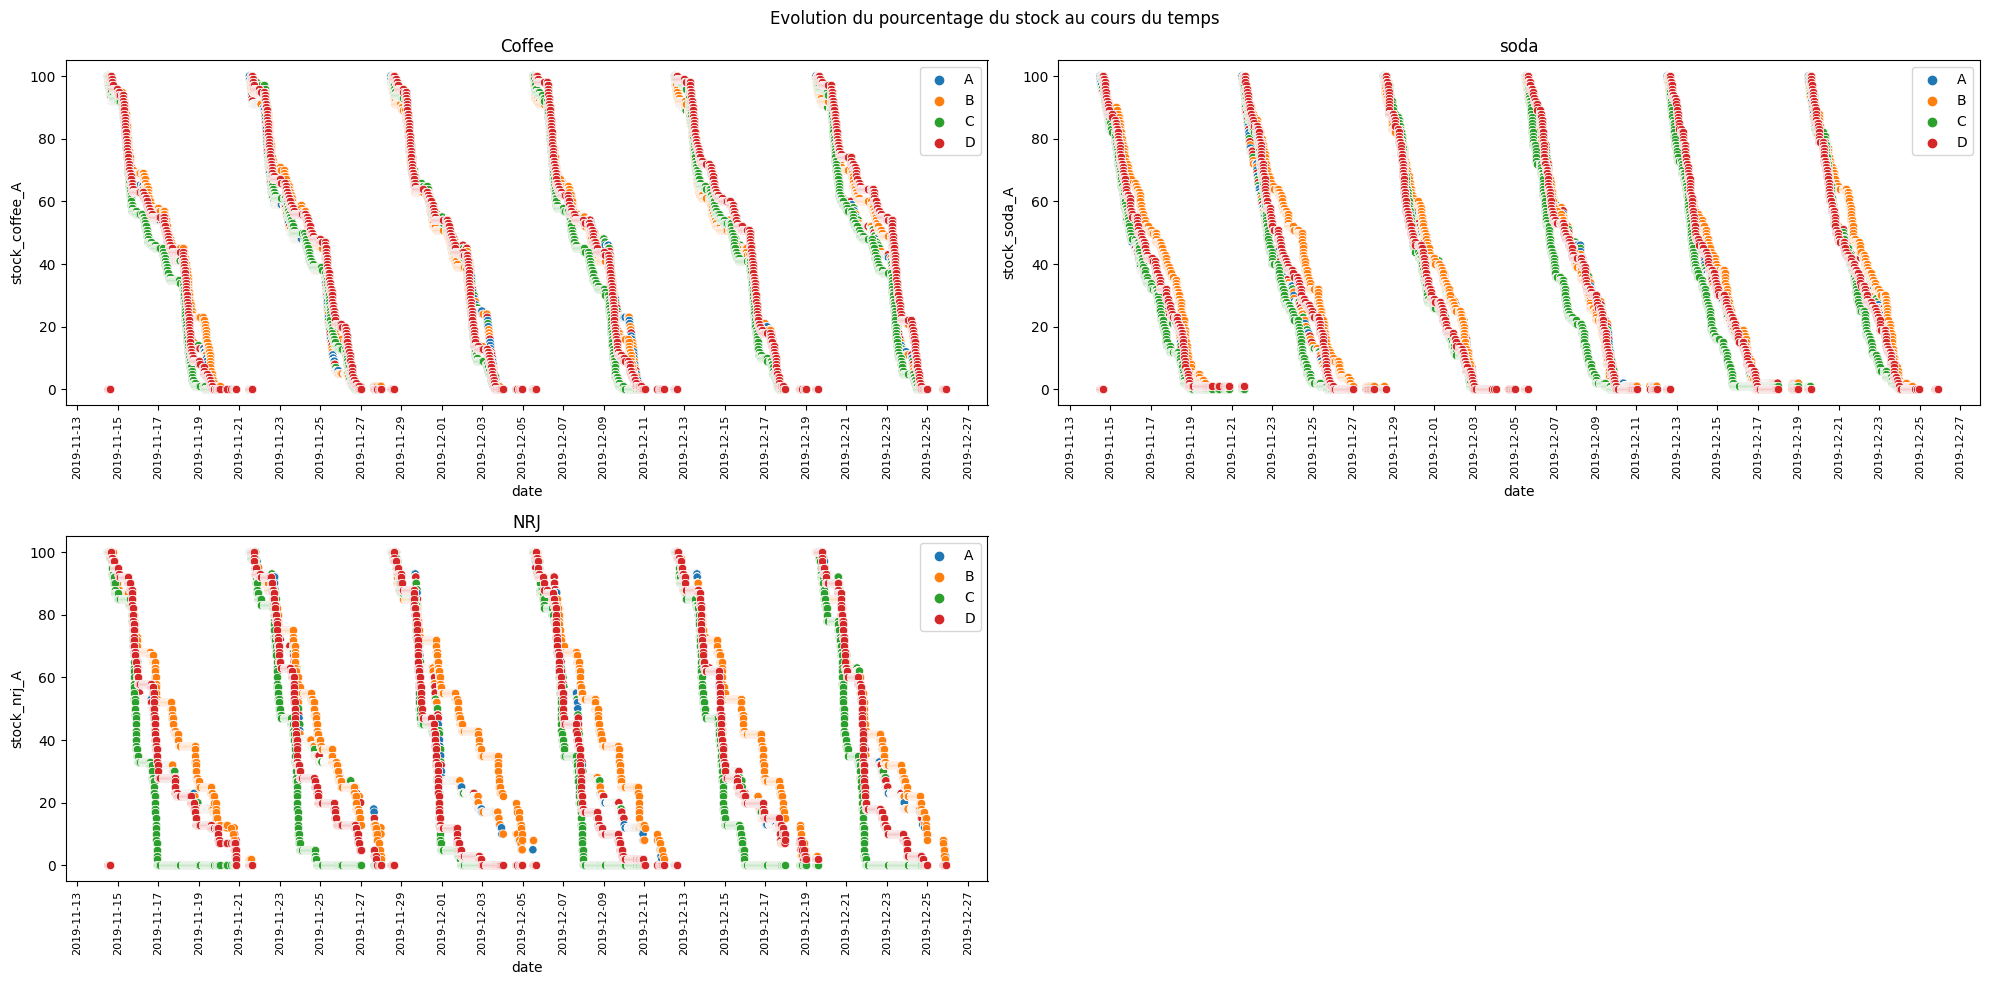

In [286]:
plt.figure(figsize=(20,10))

ax1 = plt.subplot(2, 2, 1)
ax1 = sns.scatterplot(data=coffee, 
                  x="date",
                  y="stock_coffee_A", 
                  hue="machine")
ax1 = sns.scatterplot(data=coffee, 
                  x="date",
                  y="stock_coffee_B", 
                  )
ax1 = sns.scatterplot(data=coffee, 
                  x="date",
                  y="stock_coffee_C", 
                  )
ax1 = sns.scatterplot(data=coffee,
                  x="date",
                  y="stock_coffee_D", 
                  )
plt.title("Coffee")



ax2 = plt.subplot(2, 2, 2)
ax2 = sns.scatterplot(data=soda, 
                  x="date",
                  y="stock_soda_A",
                  hue="machine")
ax2 = sns.scatterplot(data=soda, 
                  x="date",
                  y="stock_soda_B",
                  )
ax2 = sns.scatterplot(data=soda, 
                  x="date",
                  y="stock_soda_C",
                  )
ax2 = sns.scatterplot(data=soda,
                  x="date",
                  y="stock_soda_D",
                  )
plt.title("soda")


ax3 = plt.subplot(2, 2, 3)
ax3 = sns.scatterplot(data=nrj, 
                  x="date",
                  y="stock_nrj_A",
                  hue="machine")
ax3 = sns.scatterplot(data=nrj, 
                  x="date",
                  y="stock_nrj_B",
                  )
ax3 = sns.scatterplot(data=nrj, 
                  x="date",
                  y="stock_nrj_C",
                  )
ax3 = sns.scatterplot(data=nrj,
                  x="date",
                  y="stock_nrj_D",
                  )
plt.title("NRJ")

ax1.tick_params(axis='x', rotation=90, labelsize=8)
ax2.tick_params(axis='x', rotation=90, labelsize=8)
ax3.tick_params(axis='x', rotation=90, labelsize=8)
plt.suptitle("Evolution du pourcentage du stock au cours du temps")
loc = mdates.DayLocator(interval=2)
ax1.xaxis.set_major_locator(loc)
ax2.xaxis.set_major_locator(loc)
ax3.xaxis.set_major_locator(loc)
plt.tight_layout()
plt.show()


#### Conclusion : 

On observe une très forte régularité de consommation quelques soient les produits / les machines.

La machine C semble être soumise à une plus forte demande que les autres machines, quelques soient les produits.

*Energy drinks* 
La consommation en energie drinks des machines A et D sont similaires, on pourrait considerer une diminution du nombre d'emplacement 
pour la machine B (consommation faible), et plus élevée pour la machine C(consommation forte). A vérifier selon les marges faites sur chaque produit
afin de savoir ce qui est le plus rentable.

### Ventes par heure
Ce que l'on sait : les relevés de consommation semblent suffisamment régulier pour créer une visualisation sur une "semaine type"

In [288]:
df

,date,product,machine,month,day,weekday,hour,coffee_A,soda_A,nrj_A,...,stock_soda_C,stock_soda_D,stock_njr_A,stock_njr_B,stock_njr_C,stock_njr_D,stock_nrj_A,stock_nrj_B,stock_nrj_C,stock_nrj_D
0,2019-11-14 11:53:35+00:00,refill,A,11,14,thursday,11,280,120,60,...,0.0,0.0,100.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0
1,2019-11-14 12:06:35+00:00,coffee,A,11,14,thursday,12,279,120,60,...,0.0,0.0,100.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0
2,2019-11-14 12:07:59+00:00,soda,A,11,14,thursday,12,279,119,60,...,0.0,0.0,100.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0
3,2019-11-14 12:13:45+00:00,soda,A,11,14,thursday,12,279,118,60,...,0.0,0.0,100.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0
4,2019-11-14 12:22:35+00:00,coffee,A,11,14,thursday,12,278,118,60,...,0.0,0.0,100.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11031,2019-12-25 20:10:53+00:00,nrj,A,12,25,wednesday,20,0,0,3,...,0.0,0.0,5.0,5.0,0.0,0.0,5.0,5.0,0.0,0.0
11032,2019-12-25 20:16:30+00:00,nrj,B,12,25,wednesday,20,0,0,3,...,0.0,0.0,5.0,3.0,0.0,0.0,5.0,3.0,0.0,0.0
11033,2019-12-25 20:26:35+00:00,nrj,B,12,25,wednesday,20,0,0,3,...,0.0,0.0,5.0,2.0,0.0,0.0,5.0,2.0,0.0,0.0
11034,2019-12-25 21:11:55+00:00,nrj,B,12,25,wednesday,21,0,0,3,...,0.0,0.0,5.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0


In [317]:
df["test"] = df.groupby(["product", "weekday", "hour"]).cumcount()

In [318]:
df.head(50)

,date,product,machine,month,day,weekday,hour,coffee_A,soda_A,nrj_A,...,stock_soda_D,stock_njr_A,stock_njr_B,stock_njr_C,stock_njr_D,stock_nrj_A,stock_nrj_B,stock_nrj_C,stock_nrj_D,test
0,2019-11-14 11:53:35+00:00,refill,A,11,14,thursday,11,280,120,60,...,0.0,100.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0
1,2019-11-14 12:06:35+00:00,coffee,A,11,14,thursday,12,279,120,60,...,0.0,100.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0
2,2019-11-14 12:07:59+00:00,soda,A,11,14,thursday,12,279,119,60,...,0.0,100.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0
3,2019-11-14 12:13:45+00:00,soda,A,11,14,thursday,12,279,118,60,...,0.0,100.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,1
4,2019-11-14 12:22:35+00:00,coffee,A,11,14,thursday,12,278,118,60,...,0.0,100.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,1
5,2019-11-14 12:37:44+00:00,soda,A,11,14,thursday,12,278,117,60,...,0.0,100.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,2
6,2019-11-14 12:47:09+00:00,refill,B,11,14,thursday,12,278,117,60,...,0.0,100.0,100.0,0.0,0.0,100.0,100.0,0.0,0.0,0
7,2019-11-14 12:47:52+00:00,coffee,A,11,14,thursday,12,277,117,60,...,0.0,100.0,100.0,0.0,0.0,100.0,100.0,0.0,0.0,2
8,2019-11-14 12:51:00+00:00,coffee,A,11,14,thursday,12,276,117,60,...,0.0,100.0,100.0,0.0,0.0,100.0,100.0,0.0,0.0,3
9,2019-11-14 12:52:49+00:00,coffee,A,11,14,thursday,12,275,117,60,...,0.0,100.0,100.0,0.0,0.0,100.0,100.0,0.0,0.0,4


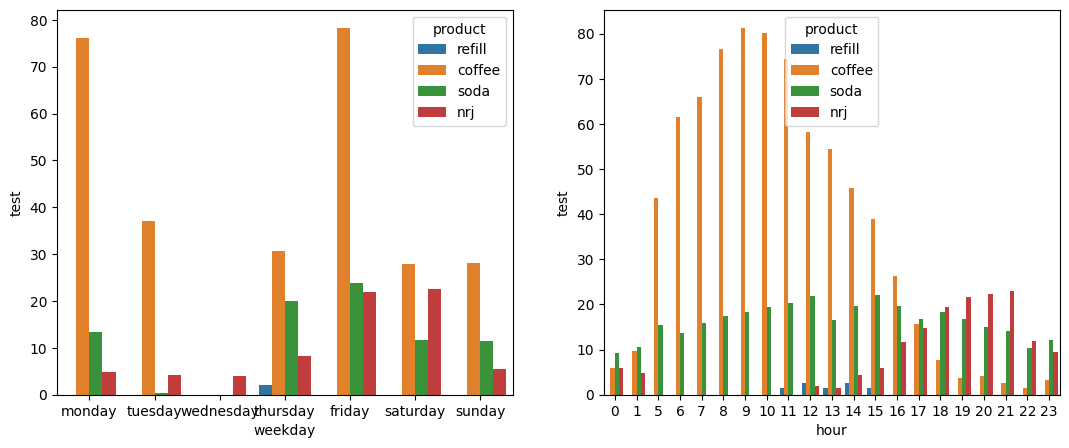

In [332]:
# Initialize the matplotlib figure
plt.figure(figsize=(20,5))
ax1 = plt.subplot(1, 3, 1)

ax1 = sns.barplot(data=df, x="weekday", y="test",  hue="product", order=["monday", "tuesday", "wednesday", "thursday", "friday", "saturday", "sunday"], errorbar=None)

ax2 = plt.subplot(1, 3, 2)
ax2 = sns.barplot(data=df, x="hour", y="test",  hue="product", errorbar=None)

### Evolution du stock par machine

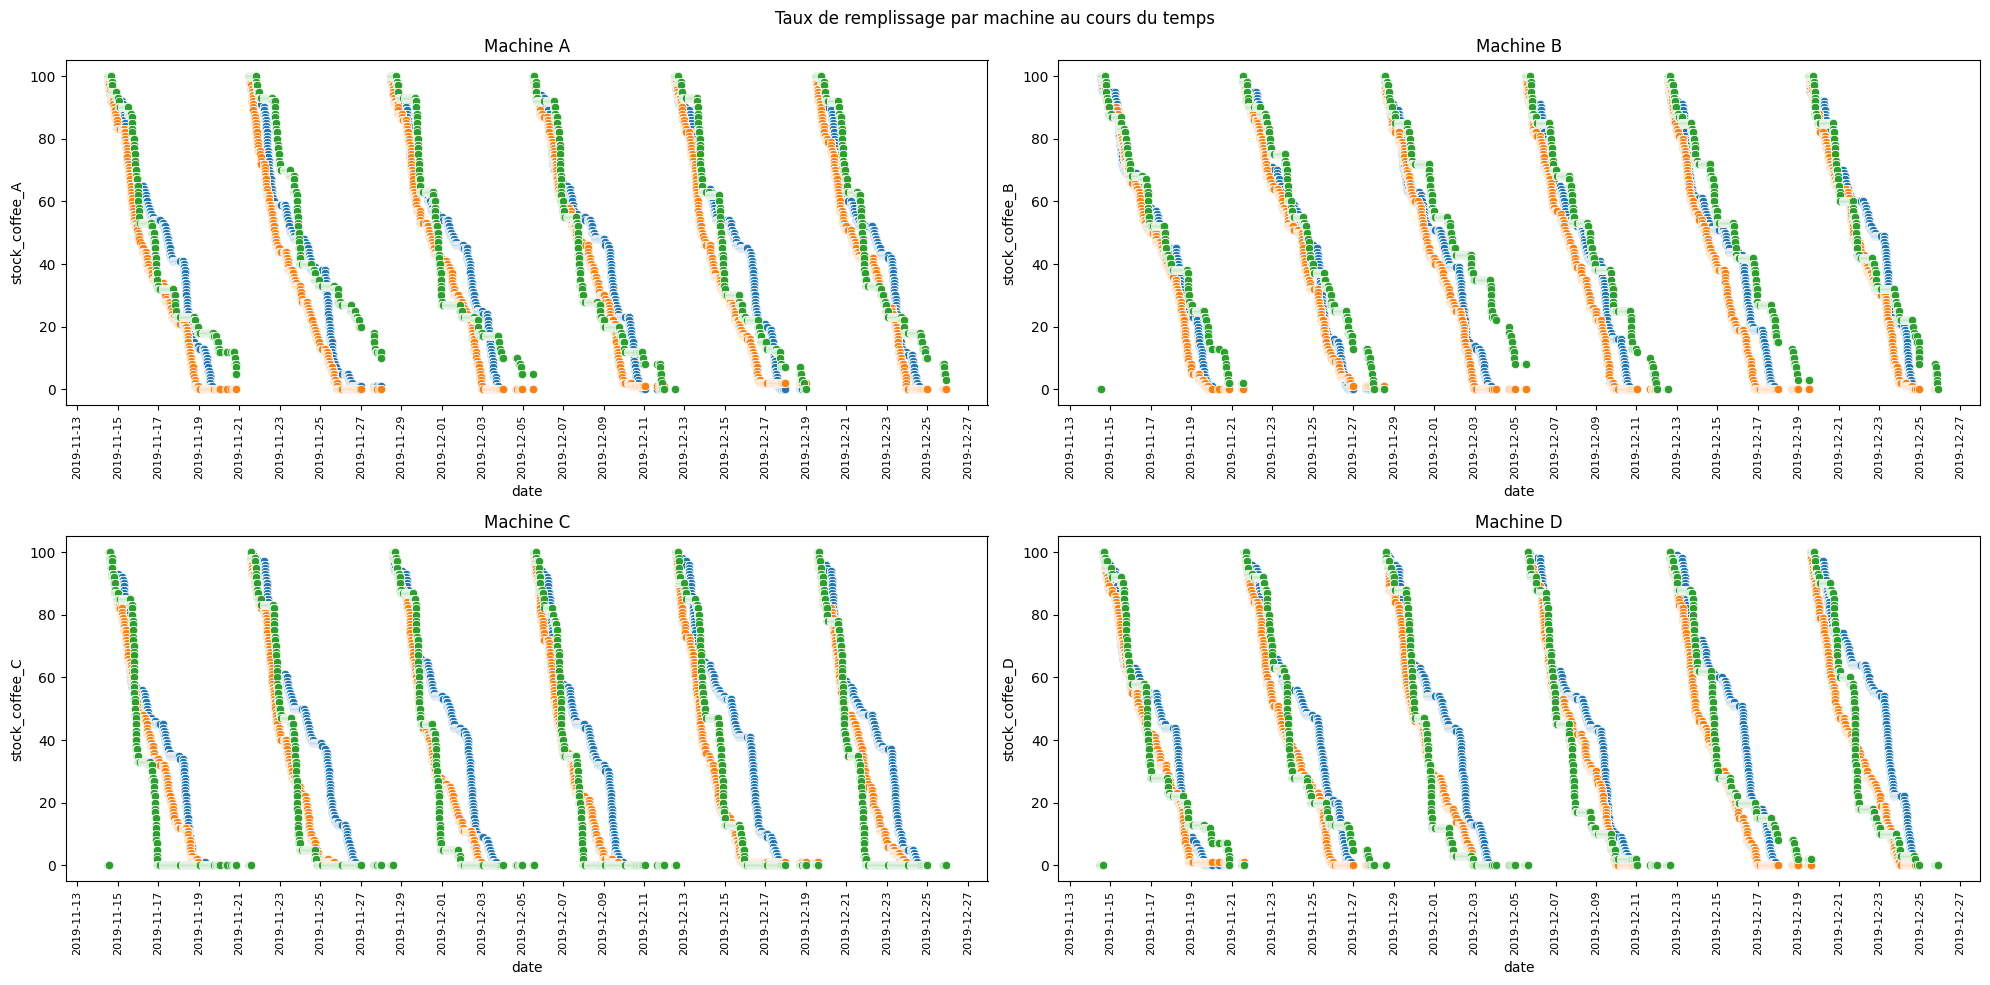

In [280]:
plt.figure(figsize=(20,10))

ax1 = plt.subplot(2, 2, 1)
ax1 = sns.scatterplot(data=df, 
                  x="date",
                  y="stock_coffee_A", 
                  )
ax1 = sns.scatterplot(data=df, 
                  x="date",
                  y="stock_soda_A", 
                  )
ax1 = sns.scatterplot(data=df, 
                  x="date",
                  y="stock_nrj_A", 
                  )

plt.title("Machine A")



ax2 = plt.subplot(2, 2, 2)
ax2 = sns.scatterplot(data=df, 
                  x="date",
                  y="stock_coffee_B", 
                  )
ax2 = sns.scatterplot(data=df, 
                  x="date",
                  y="stock_soda_B", 
                  )
ax2 = sns.scatterplot(data=df, 
                  x="date",
                  y="stock_nrj_B", 
                  )
plt.title("Machine B")


ax3 = plt.subplot(2, 2, 3)
ax3 = sns.scatterplot(data=df, 
                  x="date",
                  y="stock_coffee_C", 
                  )
ax3 = sns.scatterplot(data=df, 
                  x="date",
                  y="stock_soda_C", 
                  )
ax3 = sns.scatterplot(data=df, 
                  x="date",
                  y="stock_nrj_C", 
                  )
plt.title("Machine C")

ax4 = plt.subplot(2, 2, 4)
ax4 = sns.scatterplot(data=df, 
                  x="date",
                  y="stock_coffee_D", 
                  )
ax4 = sns.scatterplot(data=df, 
                  x="date",
                  y="stock_soda_D", 
                  )
ax4 = sns.scatterplot(data=df, 
                  x="date",
                  y="stock_nrj_D", 
                  )
plt.title("Machine D")

ax1.tick_params(axis='x', rotation=90, labelsize=8)
ax2.tick_params(axis='x', rotation=90, labelsize=8)
ax3.tick_params(axis='x', rotation=90, labelsize=8)
ax4.tick_params(axis='x', rotation=90, labelsize=8)
plt.suptitle("Taux de remplissage par machine au cours du temps")
loc = mdates.DayLocator(interval=2)
ax1.xaxis.set_major_locator(loc)
ax2.xaxis.set_major_locator(loc)
ax3.xaxis.set_major_locator(loc)
ax4.xaxis.set_major_locator(loc)
plt.tight_layout()
plt.show()


#### Conclusion 
Graphique à refaire, on ne peut pas savoir ici quel ligne represente quel produit.

orange=café, vert=nrj, bleu=soda (on peut savoir à la frequence des points en fait)

In [ ]:
# df date min = 14 nov 19, date max = 25 dec 19

## Comptabilité